In [19]:

%store -r  X
%store -r  y

%store -r  x_train
%store -r  x_test

%store -r  y_train
%store  -r y_test

%store -r col_trans

%store -r scoring

In [13]:
from sklearn.metrics import classification_report, confusion_matrix


def eval (model, x_train, y_train,x_test, y_test):
    y_train_pred = model.predict(x_train)
    y_pred = model.predict(x_test)

    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

## SVC Support Vector Classifier

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


operation_svm = [("OneHotEncode", col_trans),("svc",SVC(class_weight="balanced",random_state=101))]

pipe_svc = Pipeline(steps=operation_svm)


In [18]:
pipe_svc.fit(x_train, y_train)
eval(pipe_svc, x_train, y_train, x_test, y_test)

c:\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Test_Set
[[235  19   6]
 [ 14  89  33]
 [ 16 133 609]]
              precision    recall  f1-score   support

       Black       0.89      0.90      0.90       260
    Hispanic       0.37      0.65      0.47       136
       White       0.94      0.80      0.87       758

    accuracy                           0.81      1154
   macro avg       0.73      0.79      0.74      1154
weighted avg       0.86      0.81      0.83      1154


Train_Set
[[ 974   39   25]
 [  38  418   87]
 [  62  412 2560]]
              precision    recall  f1-score   support

       Black       0.91      0.94      0.92      1038
    Hispanic       0.48      0.77      0.59       543
       White       0.96      0.84      0.90      3034

    accuracy                           0.86      4615
   macro avg       0.78      0.85      0.80      4615
weighted avg       0.89      0.86      0.87      4615



In [23]:
import pandas as pd
from sklearn.model_selection import cross_validate


model = Pipeline(steps=operation_svm)

scores = cross_validate(
    model, x_train, y_train, scoring=scoring, cv=10, n_jobs=-1, return_train_score=True
)

df_scores = pd.DataFrame(scores, index=range(1, 11))
df_scores.mean()[2:]

test_precision_Hispanic     0.381641
train_precision_Hispanic    0.481422
test_f1_Hispanic            0.472541
train_f1_Hispanic           0.594278
test_recall_Hispanic        0.624242
train_recall_Hispanic       0.776344
dtype: float64

## Gridsearch CV

In [24]:
## Gridsearch CV
svc_c = [0.5 , 1]
svc_gamma = ["scale", "auto", 0.01]

params_grid = {"svc__C":svc_c, "svc__gamma":svc_gamma}


In [25]:
operation_svm = [("OneHotEncode", col_trans),("svc",SVC(class_weight="balanced",random_state=101))]

pipe_svc = Pipeline(steps=operation_svm)

In [26]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV

recall_Hispanic =  make_scorer(recall_score, average=None, labels=["Hispanic"])

svm_model_grid = GridSearchCV(
    model,
    params_grid,
    scoring=recall_Hispanic,
    cv=10,
    n_jobs=-1,
    return_train_score=True,
)


In [27]:
svm_model_grid.fit(x_train, y_train)

c:\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('OneHotEncode',
                                        ColumnTransformer(remainder=MinMaxScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         Index(['Gender', 'WritingPreference'], dtype='object'))])),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            random_state=101))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.5, 1],
                         'svc__gamma': ['scale', 'auto', 0.01]},
             return_train_score=True,
             scoring=make_scorer(recall_score, average=None, labels=['Hispanic']))

In [28]:
svm_model_grid.best_estimator_

Pipeline(steps=[('OneHotEncode',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['Gender', 'WritingPreference'], dtype='object'))])),
                ('svc',
                 SVC(C=1, class_weight='balanced', gamma='auto',
                     random_state=101))])

In [29]:
pd.DataFrame(svm_model_grid.cv_results_)[["mean_test_score", "mean_train_score"]]

,mean_test_score,mean_train_score
0,0.648283,0.732550
1,0.637273,0.654181
2,0.639125,0.654797
3,0.624242,0.776344
4,0.657508,0.674648
5,0.657508,0.675466


In [32]:
pd.DataFrame(svm_model_grid.cv_results_).loc[
    svm_model_grid.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.657508
mean_train_score    0.674648
Name: 4, dtype: object

In [34]:
svm_model_grid.best_params_

{'svc__C': 1, 'svc__gamma': 'auto'}

In [33]:
eval(svm_model_grid, x_train, y_train, x_test, y_test)

Test_Set
[[225  28   7]
 [ 11  92  33]
 [ 21 232 505]]
              precision    recall  f1-score   support

       Black       0.88      0.87      0.87       260
    Hispanic       0.26      0.68      0.38       136
       White       0.93      0.67      0.78       758

    accuracy                           0.71      1154
   macro avg       0.69      0.74      0.67      1154
weighted avg       0.84      0.71      0.75      1154


Train_Set
[[ 901   85   52]
 [  57  364  122]
 [  90  793 2151]]
              precision    recall  f1-score   support

       Black       0.86      0.87      0.86      1038
    Hispanic       0.29      0.67      0.41       543
       White       0.93      0.71      0.80      3034

    accuracy                           0.74      4615
   macro avg       0.69      0.75      0.69      4615
weighted avg       0.84      0.74      0.77      4615



c:\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


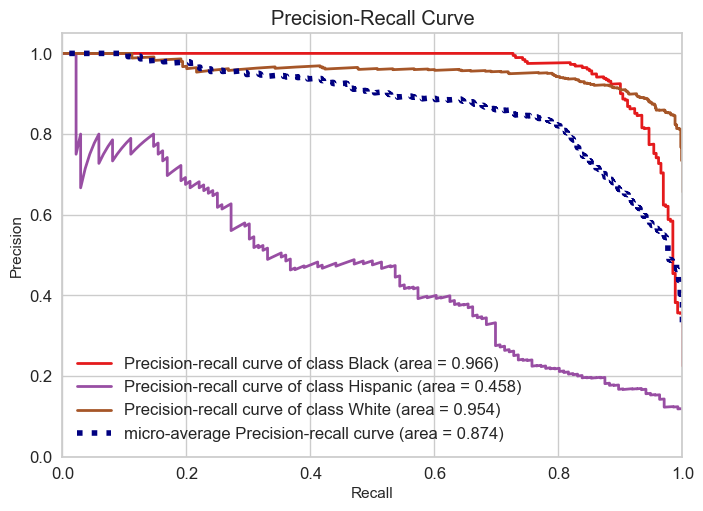

In [49]:
from scikitplot.metrics import plot_roc, plot_precision_recall
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from yellowbrick.classifier import PrecisionRecallCurve

operations = [
    ("OneHotEncoder", col_trans),
    ("svc", SVC(C=1, class_weight="balanced", random_state=101)),
]

model = Pipeline(steps=operations)

model.fit(x_train, y_train)

decision_function = model.decision_function(x_test)

plot_precision_recall(y_test, decision_function, cmap='Set1')
plt.show();



In [39]:
decision_function

array([[ 2.20585269,  0.87540309, -0.16814231],
       [-0.2650925 ,  1.06319956,  2.26165961],
       [-0.22061529,  0.86143499,  2.24247379],
       ...,
       [ 2.25770533,  0.8566136 , -0.24207569],
       [-0.27515494,  1.20661565,  2.25201238],
       [-0.23510253,  0.97548309,  2.23734816]])

In [40]:
model.classes_

array(['Black', 'Hispanic', 'White'], dtype=object)

In [51]:
from sklearn.metrics import average_precision_score


y_pred = svm_model_grid.predict(x_test)


In [52]:
from sklearn.metrics import average_precision_score

y_test_dummies = pd.get_dummies(y_test).values  # we do that for the sake of the average_precision_score function.


In [53]:
average_precision_score(y_test_dummies[:, 1], decision_function[:, 1])

0.45794836398095845

In [56]:
from sklearn.metrics import f1_score


y_pred = svm_model_grid.predict(x_test)

svc_AP = average_precision_score(y_test_dummies[:, 1], decision_function[:, 1])
svc_f1 = f1_score(y_test, y_pred, average=None, labels=["Hispanic"])
svc_recall = recall_score(y_test, y_pred, average=None, labels=["Hispanic"])

In [57]:
%store svc_AP
%store svc_f1
%store svc_recall

Stored 'svc_AP' (float64)
Stored 'svc_f1' (ndarray)
Stored 'svc_recall' (ndarray)
